<a href="https://colab.research.google.com/github/Axel0087/NLP2023/blob/Simone-dev/Unigram_week2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install datasets

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import nltk
import string
from datasets import load_dataset
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
dataset = load_dataset("copenlu/answerable_tydiqa")

In [5]:
train_set = dataset["train"]
validation_set = dataset["validation"]

In [6]:
def get_answer_start(row):
  return row["annotations"]["answer_start"][0]

def get_answer(row):
  return row["annotations"]["answer_text"][0]

def get_document(row):
  return row["document_plaintext"]

def get_question(row):
  return row["question_text"]

def oracle(answer, document):
  return answer != "" and answer in document

def get_language(dataset, lang):
  return [row for row in dataset if row['language'] == lang]

In [7]:
train_arabic = get_language(train_set, "arabic")
val_arabic = get_language(validation_set, "arabic")

train_bengali = get_language(train_set, "bengali")
val_bengali = get_language(validation_set, "bengali")

train_indonesian = get_language(train_set, "indonesian")
val_indonesian = get_language(validation_set, "indonesian")

In [8]:
train_arabic_doc = [get_document(row) for row in train_arabic]
train_arabic_question = [get_question(row) for row in train_arabic]

train_bengali_doc = [get_document(row) for row in train_bengali]
train_bengali_question = [get_question(row) for row in train_bengali]

train_indonesian_doc = [get_document(row) for row in train_indonesian]
train_indonesian_question = [get_question(row) for row in train_indonesian]

# **Tokenize**

In [9]:
import string

In [10]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [11]:
string.punctuation = string.punctuation +'"'+'"'+'-'+'''+'''+'—'


In [12]:
def tokenize(text,removal_list):
    # Tokenize the text and convert to lowercase
    tokens = nltk.word_tokenize(text.lower())
    # Filter out tokens that are both in removal list
    cleaned_tokens = [token for token in tokens if token not in removal_list]

    return cleaned_tokens

## removal_list

In [13]:
english_removal_list =  list(string.punctuation)+ ['lt','rt'] + ["``","´´", "''"] #+ list(set(stopwords.words('english')))
arabic_removal_list =  list(string.punctuation)+ ["؟"]+ ['lt','rt'] + ["``","´´", "''"] #list(set(stopwords.words('arabic'))) +
bengali_removal_list =  list(string.punctuation)+ ['lt','rt'] + ["``","´´", "''"] #list(set(stopwords.words('bengali')))
indonesian_removal_list =  list(string.punctuation)+ ['lt','rt'] + ["``","´´", "''"] #list(set(stopwords.words('indonesian'))) +


In [14]:
tokenized_arabic_document = [tokenize(item,arabic_removal_list) for item in train_arabic_doc]


## Arabic

In [15]:
#Train set
tokenized_arabic_document = [tokenize(item,arabic_removal_list) for item in train_arabic_doc]
tokenized_arabic_question = [tokenize(item,arabic_removal_list) for item in train_arabic_question]

#Validation set
val_tokenized_arabic_document = [tokenize(item['document_plaintext'],arabic_removal_list) for item in val_arabic]
val_tokenized_arabic_question = [tokenize(item['question_text'],arabic_removal_list) for item in val_arabic]


## Bengali

In [16]:
tokenized_bengali_document = [tokenize(item,bengali_removal_list) for item in train_bengali_doc]
tokenized_bengali_question = [tokenize(item,bengali_removal_list) for item in train_bengali_question]

val_tokenized_bengali_document = [tokenize(item['document_plaintext'],bengali_removal_list) for item in val_bengali]
val_tokenized_bengali_question = [tokenize(item['question_text'],bengali_removal_list) for item in val_bengali]


In [17]:
val_tokenized_bengali_question[0]

['পশ্চিম',
 'ভারতের',
 'মহারাষ্ট্র',
 'রাজ্যের',
 'মুম্বাই',
 'শহরে',
 'নির্মিত',
 'গেটওয়ে',
 'অব',
 'ইন্ডিয়া',
 'স্থাপত্যটির',
 'ভিত্তিপ্রস্তর',
 'স্থাপন',
 'করেন',
 'কে']

Translated to this
'পশ্চিম' - West
'ভারতের' - of India
'মহারাষ্ট্র' - Maharashtra
'রাজ্যের' - state's
'মুম্বাই' - Mumbai
'শহরে' - in the city
'নির্মিত' - constructed
'গেটওয়ে' - gateway
'অব' - of
'ইন্ডিয়া' - India
'স্থাপত্যটির' - architectural
'ভিত্তিপ্রস্তর' - landmark's
'স্থাপন' - establishment

## Indonesia

In [18]:
tokenized_indonesian_document = [tokenize(item,indonesian_removal_list) for item in train_indonesian_doc]
tokenized_indonesian_question = [tokenize(item,indonesian_removal_list) for item in train_indonesian_question]

val_tokenized_indonesian_document = [tokenize(item['document_plaintext'],indonesian_removal_list) for item in val_indonesian]
val_tokenized_indonesian_question = [tokenize(item['question_text'],indonesian_removal_list) for item in val_indonesian]

In [19]:
val_tokenized_indonesian_question[0]

['siapakah', 'yang', 'menemuka', 'benua', 'amerika']

translates to "siapakah" - Who
"yang" - that/who
"menemuka" - discovered/found
"benua" - continent
"amerika" - America

In [20]:
from nltk import ngrams

# Language Models

 **Inserting Out-of-Vocabularly Tokens**

In [21]:
OOV = '[OOV]'
def inject_OOVs(data):
    """
    Uses a heuristic to inject OOV symbols into a dataset.
    Args:
        data: the sequence of words to inject OOVs into.

    Returns: the new sequence with OOV symbols injected.
    """
    seen = set()
    result= []
    for sentence in data:
      sentence_result = []

      for word in sentence:
          if word in seen:
              sentence_result.append(word)
          else:
              sentence_result.append(OOV)
              seen.add(word)
      result.append(sentence_result)
    return result

def replace_OOVs(vocab,data):
    """
    Replace every word not within the vocabulary with the `OOV` symbol.
    Args:
        vocab: the reference vocabulary.
        data: the sequence of tokens to replace words within

    Returns:
        a version of `data` where each word not in `vocab` is replaced by the `OOV` symbol.
    """
    result= []
    for sentence in data:
      sentence_result = []

      for word in sentence:
        if word in vocab:
              sentence_result.append(word)
        else :
              sentence_result.append(OOV)
      result.append(sentence_result)
    return result

In [22]:
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm import MLE


In [23]:
def get_gram(text_list,n):
    gram_array = []

    # Iterate through the input list of text
    for text in text_list:

        # Generate n-grams as strings
        gram_array.append([ gram for gram in ngrams(text, n)])

    return  [item for sublist in gram_array for item in sublist]

In [24]:
class N_grams:

  def __init__(self, trainset,n):
    #tokenized dataset
    self.trainset = trainset
    self.n = n
    self.train, self.vocab_2 = padded_everygram_pipeline(n, trainset)
    self.lm = None

  def fitModel(self):
    self.lm = MLE(self.n)
    self.lm.fit(self.train, self.vocab_2)

  def get_vocab(self):
    return self.lm.vocab

  def probability(self, word, history=''):
        return(self.lm.score(word, history.split()))

  def perplexity(self,valset):
      return self.lm.perplexity(get_gram(valset,self.n))


In [25]:
def plot_prob(lm,context='',amount = 10):
  probs = sorted([(word,lm.probability(word,context)) for word in lm.get_vocab()], key=lambda x:x[1], reverse=True)[:amount]
  df_probs=pd.DataFrame(probs)
  pd1=df_probs[0][:10]
  pd2=df_probs[1][:10]

  plt.figure(1,figsize=(16,4))

  plt.bar(pd1,pd2, color ='green',  width = 0.4)

  plt.xlabel("Words in questions")
  plt.ylabel("Probability")
  plt.title(f"Top {amount} words in the model")
  return plt, probs



# **Arabic**

In [26]:
perplexity ={}
probabilities = {}

### Document

In [27]:
tokenized_arabic_document_oov = inject_OOVs(tokenized_arabic_document)

In [28]:
unigram_arabic_document_oov = N_grams(tokenized_arabic_document_oov,1)
unigram_arabic_document_oov.fitModel()

In [29]:
oov_val_arabic_document  = replace_OOVs(unigram_arabic_document_oov.get_vocab(),val_tokenized_arabic_document)
perplexity['Arabic','document']= unigram_arabic_document_oov.perplexity(oov_val_arabic_document)

### plot

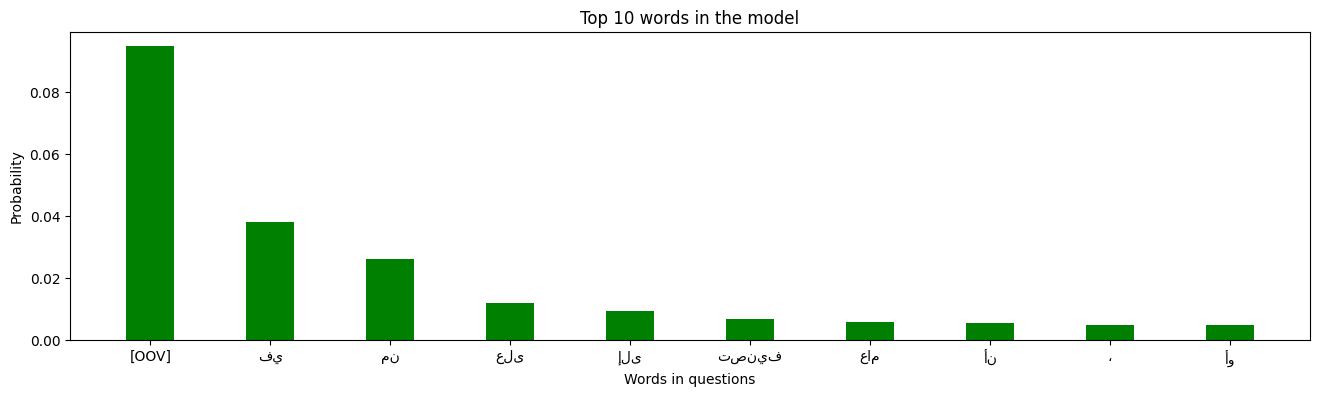

In [30]:
plot , probabilities['Arabic','document'] = plot_prob(unigram_arabic_document_oov)

## Questions

In [31]:
tokenized_arabic_question_oov = inject_OOVs(tokenized_arabic_question)

In [32]:
unigram_arabic_question_oov = N_grams(tokenized_arabic_question_oov,1)
unigram_arabic_question_oov.fitModel()

In [33]:
oov_val_arabic_question  = replace_OOVs(unigram_arabic_question_oov.get_vocab(),val_tokenized_arabic_question)
perplexity['Arabic','question']= unigram_arabic_question_oov.perplexity(oov_val_arabic_question)

### plot

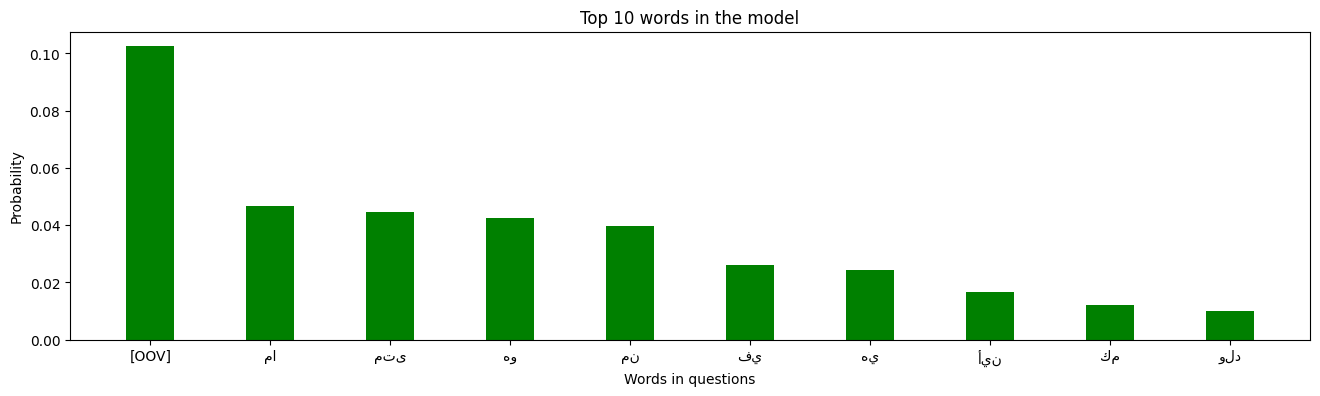

In [34]:
plot , probabilities['Arabic','question'] = plot_prob(unigram_arabic_question_oov)

# **Bengali**

## document


In [35]:
tokenized_bengali_document_oov =inject_OOVs(tokenized_bengali_document)

In [36]:
unigram_bengali_document_oov = N_grams(tokenized_bengali_document_oov,1)
unigram_bengali_document_oov.fitModel()

In [37]:
oov_val_bengali_document = replace_OOVs(unigram_bengali_document_oov.get_vocab(),val_tokenized_bengali_document)
perplexity['Bengali','document']=  unigram_bengali_document_oov.perplexity(oov_val_bengali_document)

### plot

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 2451 (\N{BENGALI LETTER O}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Matplotlib currently does not support Bengali natively.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 2447 (\N{BENGALI LETTER E}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 2476 (\N{BENGALI LETTER BA}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 2434 (\N{BENGALI SIGN ANUSVARA}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 2439 (\N{BENGALI LETTER I}) missing from current font.
  func(*args, **kwargs)
/usr/loca

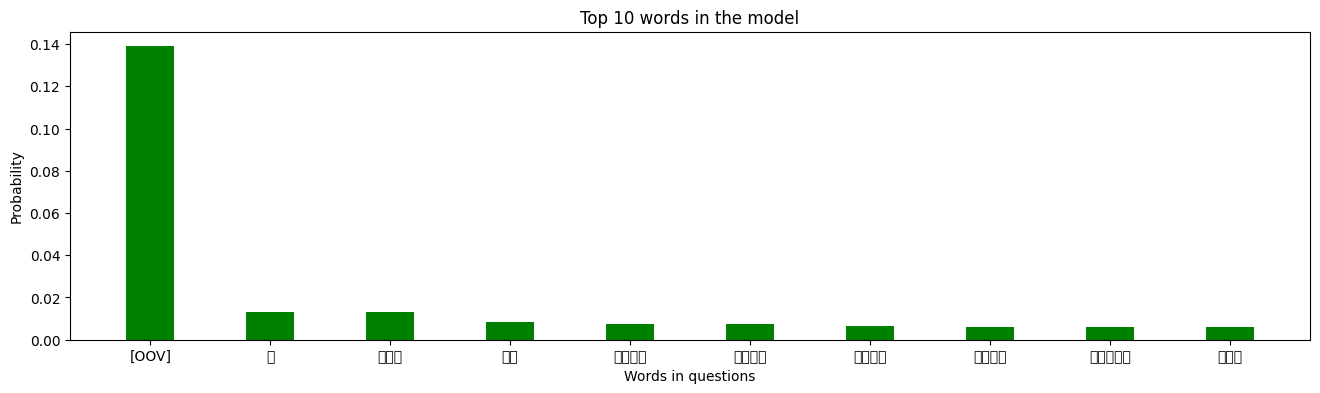

In [38]:
plot , probabilities['Bengali','document'] = plot_prob(unigram_bengali_document_oov)

## question

In [39]:
tokenized_bengali_question_oov =inject_OOVs(tokenized_bengali_question)


In [40]:
unigram_bengali_question_oov = N_grams(tokenized_bengali_question_oov,1)
unigram_bengali_question_oov.fitModel()

In [41]:
oov_val_bengali_question = replace_OOVs(unigram_bengali_question_oov.get_vocab(),val_tokenized_bengali_question)

perplexity['Bengali','question']= unigram_bengali_question_oov.perplexity(oov_val_bengali_question)

### plot

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 2496 (\N{BENGALI VOWEL SIGN II}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 2478 (\N{BENGALI LETTER MA}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 2527 (\N{BENGALI LETTER YYA}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 2507 (\N{BENGALI VOWEL SIGN O}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 2474 (\N{BENGALI LETTER PA}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 2509 (\N{BENGALI SIGN VIRAMA}) missing from current font.
  func(*args, **kw

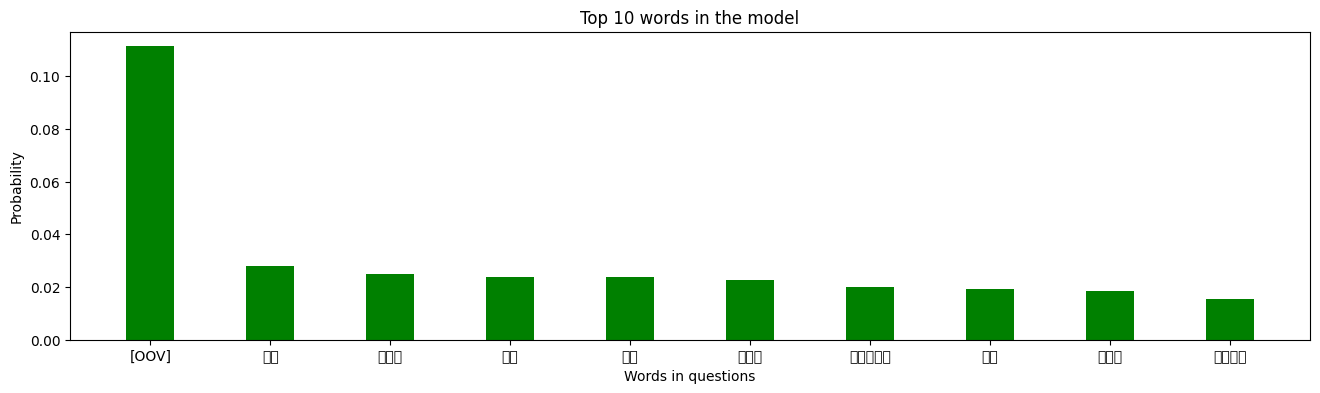

In [42]:
plot , probabilities['Bengali','question'] = plot_prob(unigram_bengali_question_oov)

# **indonesian**

## document

In [43]:
tokenized_indonesian_document_oov = inject_OOVs(tokenized_indonesian_document)

In [44]:
unigram_indonesian_document_oov = N_grams(tokenized_indonesian_document_oov,1)
unigram_indonesian_document_oov.fitModel()

In [45]:
unigram_indonesian_document_oov = N_grams(tokenized_indonesian_document_oov,1)
unigram_indonesian_document_oov.fitModel()

In [46]:
oov_val_indonesian_document = replace_OOVs(unigram_indonesian_document_oov.get_vocab(),val_tokenized_indonesian_document)
perplexity['Indonesian','document']=  unigram_indonesian_document_oov.perplexity(oov_val_indonesian_document)

### plot

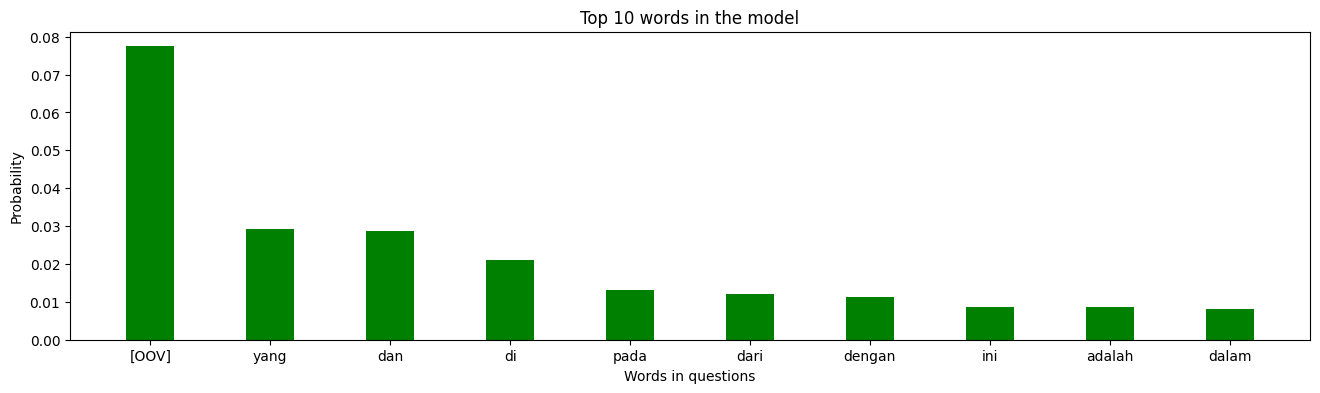

In [47]:
plot , probabilities['Indonesian','document'] = plot_prob(unigram_indonesian_document_oov)

## question

In [48]:
tokenized_indonesian_question_oov =inject_OOVs(tokenized_indonesian_question)

In [49]:
unigram_indonesian_question_oov = N_grams(tokenized_indonesian_question_oov,1)
unigram_indonesian_question_oov.fitModel()

In [50]:
oov_val_indonesian_question = replace_OOVs(unigram_indonesian_question_oov.get_vocab(),val_tokenized_indonesian_question)

perplexity['Indonesian','question']= unigram_indonesian_question_oov.perplexity(oov_val_indonesian_question)

### plot

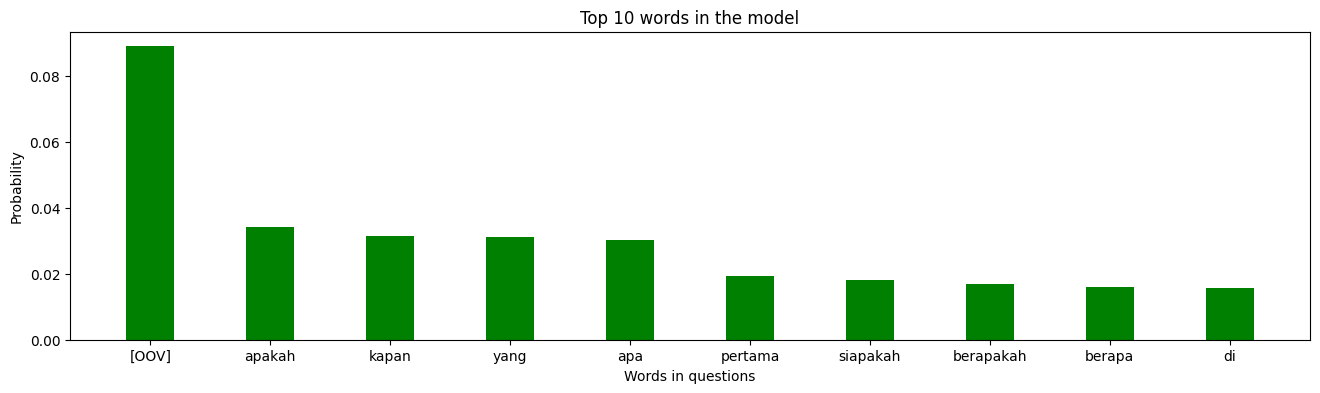

In [51]:
plot , probabilities['Indonesian','question'] = plot_prob(unigram_indonesian_question_oov)

# Results

In [52]:
# Create an empty DataFrame with languages as columns
languages = set(lang for lang, _ in perplexity.keys())
df = pd.DataFrame(columns=list(languages))

# Fill the DataFrame with data from the  dictionary
for (lang, category), value in perplexity.items():
    df.loc[category, lang] = value

# Fill NaN values with 0
df.fillna(0, inplace=True)

# Display the DataFrame
df


,Indonesian,Arabic,Bengali
document,1497.28194,4068.173156,1457.91529
question,214.683546,359.364842,242.260268


In [53]:
probabilities

{('Arabic', 'document'): [('[OOV]', 0.09474081482141297),
  ('في', 0.03786913904108808),
  ('من', 0.026054663374407767),
  ('على', 0.011846137414518558),
  ('إلى', 0.00932417366004317),
  ('تصنيف', 0.006608440008797744),
  ('عام', 0.005757794383543659),
  ('أن', 0.0052706256234725845),
  ('،', 0.004636968510069913),
  ('أو', 0.004566046194912253)],
 ('Arabic', 'question'): [('[OOV]', 0.10253675917097406),
  ('ما', 0.04673307572640136),
  ('متى', 0.04471947608772018),
  ('هو', 0.04239850454157675),
  ('من', 0.03956942841371004),
  ('في', 0.026038791589300947),
  ('هي', 0.024407838610929895),
  ('أين', 0.016698449340091334),
  ('كم', 0.01198750439102725),
  ('ولد', 0.0098045365584383)],
 ('Bengali', 'document'): [('[OOV]', 0.1389085881338551),
  ('ও', 0.013249797196981678),
  ('এবং', 0.013012555930266373),
  ('এই', 0.008545787564476054),
  ('হয়।', 0.007436110671775432),
  ('তিনি', 0.007425906746325311),
  ('থেকে', 0.00632898476043734),
  ('সালে', 0.006030519941021311),
  ('করেন।', 0.006

In [54]:
# Create a DataFrame
df = pd.DataFrame.from_dict(probabilities, orient='columns')

# Rename the columns for clarity
df.columns = pd.MultiIndex.from_tuples(df.columns, names=['Language', 'Category'])

# Display the DataFrame
print(df)
# Display the DataFrame
df

probabilities

Language                         Arabic                                \
Category                       document                      question   
0          ([OOV], 0.09474081482141297)  ([OOV], 0.10253675917097406)   
1             (في, 0.03786913904108808)     (ما, 0.04673307572640136)   
2            (من, 0.026054663374407767)    (متى, 0.04471947608772018)   
3           (على, 0.011846137414518558)     (هو, 0.04239850454157675)   
4            (إلى, 0.00932417366004317)     (من, 0.03956942841371004)   
5         (تصنيف, 0.006608440008797744)    (في, 0.026038791589300947)   
6           (عام, 0.005757794383543659)    (هي, 0.024407838610929895)   
7           (أن, 0.0052706256234725845)   (أين, 0.016698449340091334)   
8             (،, 0.004636968510069913)     (كم, 0.01198750439102725)   
9            (أو, 0.004566046194912253)     (ولد, 0.0098045365584383)   

Language                        Bengali                                \
Category                       document           

{('Arabic', 'document'): [('[OOV]', 0.09474081482141297),
  ('في', 0.03786913904108808),
  ('من', 0.026054663374407767),
  ('على', 0.011846137414518558),
  ('إلى', 0.00932417366004317),
  ('تصنيف', 0.006608440008797744),
  ('عام', 0.005757794383543659),
  ('أن', 0.0052706256234725845),
  ('،', 0.004636968510069913),
  ('أو', 0.004566046194912253)],
 ('Arabic', 'question'): [('[OOV]', 0.10253675917097406),
  ('ما', 0.04673307572640136),
  ('متى', 0.04471947608772018),
  ('هو', 0.04239850454157675),
  ('من', 0.03956942841371004),
  ('في', 0.026038791589300947),
  ('هي', 0.024407838610929895),
  ('أين', 0.016698449340091334),
  ('كم', 0.01198750439102725),
  ('ولد', 0.0098045365584383)],
 ('Bengali', 'document'): [('[OOV]', 0.1389085881338551),
  ('ও', 0.013249797196981678),
  ('এবং', 0.013012555930266373),
  ('এই', 0.008545787564476054),
  ('হয়।', 0.007436110671775432),
  ('তিনি', 0.007425906746325311),
  ('থেকে', 0.00632898476043734),
  ('সালে', 0.006030519941021311),
  ('করেন।', 0.006